# Implementation of “Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering”, TIP’2020
## Introduction

With the development of deep learning and task-specific dataset, the task of image segmentation is dominated by various supervised learning-based deep neural networks with impressive performance. However, one of the big problem of supervised learning is data hungry. This work is a pioneer in exploring how image segmentation can be achieved using neural networks (CNNs) in an unsupervised manner.

Before we dive into the details of the method. Let's take a look at the three principle rules behind this method.
1. **Pixels of similar features should be assigned the same label.**
2. **Spatially continuous pixels should be assigned the same label.**
3. **The number of unique cluster labels should be large.**

## Methodology

The overview of the proposed method is as follows:
<img src="paper_imgs/pipeline.png" alt="drawing" width="1800"/>

Let's follow the specific code to understand this method step by step.

The proposed network structure is very simple consisting of three convolutional layers and the commonly used activation layer ReLU and BatchNorm operations. The dimension of the input is 3 (RGB channel) and the dimension of the rest of the convolution operation is set to 100.

In [68]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from IPython import display
from statistics import mode


class SegNet(nn.Module):
    def __init__(self, inp_dim=3, ch_dim=100):
        super(SegNet, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(inp_dim, ch_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(ch_dim),

            nn.Conv2d(ch_dim, ch_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(ch_dim),

            nn.Conv2d(ch_dim, ch_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(ch_dim),
        )

    def forward(self, x):
        return self.seq(x)


inp_dim = 3  # rgb image
ch_dim = 100
model = SegNet(inp_dim=inp_dim, ch_dim=ch_dim)
device = torch.device('cuda:0')
model = model.to(device)
model.train()
print(model)

SegNet(
  (seq): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


The learning target of this network is to minimize the following loss function:
$\mathcal{L} = \mathcal{L}_{sim}\left( \{O,\ L\} \right) + \lambda_1 \mathcal{L}_{con}\left( \{O\} \right)$,
where $\mathcal{L}_{sim}$ is the loss that aims to add constraint on feature similarity (**rule 1**), and $\mathcal{L}_{con}$ is the loss that aims to add constraint on spatial continuity (**rule 2**). Specifically, we can obtain the feature $O$ by feeding RGB images into the predefined network.
```python
img_path = './demo.jpg'
data_range = 255.
img = cv2.imread(img_path)
img_tensor = torch.from_numpy(img).float() / data_range
img_tensor = rearrange(img_tensor, 'h w c -> c h w')[None].to(device)  # shape: 1 c h w
out = model(img_tensor)[0]
```
The key idea of $\mathcal{L}_{sim}$ is to generate pseudo labels $L$ for the feature by applying the argmax function to the feature itself. In other word, for each pixel of feature, the channel index that has the maximum value will be used as the ground-truth cluster class. The objective behind this loss function is to enhance the
similarity of the similar features. Once the image pixels are clustered based on their features, the feature vectors within the same cluster should be similar to each other, and the feature vectors from different clusters should be different from each other. Through the minimization of this loss function, the network weights are updated to facilitate extraction of more efficient features for clustering.
```python
 # calculate similarity loss
out = rearrange(out, 'c h w -> (h w) c')
_, label = torch.max(out, dim=1)
label_np = label.detach().cpu().numpy()
unique_label, inverse_indices = np.unique(label_np, return_inverse=True)
num_labels = len(unique_label)
```
While the support behind $\mathcal{L}_{con}$ is that the clusters of image pixels in the task of image segmentation should preferably be spatially continuous. Therefore, the goal is to minimize the L1-norm of bhorizontal and vertical differences of the feature $O$.
```python
# calculate spatial smoothing loss
out_h_diff = out[1:, :, :] - out[:-1, :, :]
out_w_diff = out[:, 1:, :] - out[:, :-1, :]
loss_spatial_x = F.l1_loss(out_h_diff, torch.zeros_like(out_h_diff))
loss_spatial_y = F.l1_loss(out_w_diff, torch.zeros_like(out_w_diff))
loss_total = loss_spatial_y + loss_spatial_y
```
We have already described the implementation of **rule 1** and **rule 2**. So the question is what is the purpose of **rule 3** and how is it implemented?
The reason is that **rule 1** and **rule 2** only facilitate the grouping of pixels, which could lead to a simple solution with only one cluster, namely undersegmentation. To avoid this kind of trivial solution, **rule 3** is introduced. The proposed solution is to insert the intra-axis normalization process for the output feature before assigning cluster labels using the argmax classification. Here, batch normalization is used. This operation gives each channel index an even chance of obtaining a maximum value in all channels. Consequently, this intra-axis normalization process gives the proposed system a preference for a large number of cluster classes. This operation has already been completed, *i.e.*, let the last layer of the network be a BatchNorm2d layer.

In addition, this method provides an optional input interface as the scribble from users. The prior from user can be used as a partial similarity loss. In short, pixels of feature at the same scribble are forced to be treated as the same cluster class. Then the total loss can be rewritten as follows:
$\mathcal{L} = \mathcal{L}_{sim}\left( \{O,\ L\} \right) + \lambda_1 \mathcal{L}_{con}\left( \{O\} \right) + \lambda_2 \mathcal{L}_{src}\left( \{O,\ L,\ S\} \right),$
where $S$ denotes the scribble from the user.
```python
img_scribble = cv2.imread(scribble_path, flags=cv2.IMREAD_UNCHANGED)
img_scribble_flatten = img_scribble.flatten()
indices_scribble = torch.from_numpy(np.where(img_scribble_flatten != 255)[0]).to(device)
indices_not_scribble = torch.from_numpy(np.where(img_scribble_flatten == 255)[0]).to(device)
scribble_label = torch.from_numpy(img_scribble_flatten % ch_dim).long().to(device)
# modified similarity loss
loss_similarity = F.cross_entropy(out[indices_not_scribble], label[indices_not_scribble]) + 0.5 * F.cross_entropy(out[indices_scribble], scribble_label[indices_scribble])
```

The complete code is shown as follows:

In [69]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from IPython import display
from statistics import mode

torch.cuda.manual_seed_all(39)
np.random.seed(39)


class SegNet(nn.Module):
    def __init__(self, inp_dim=3, ch_dim=100):
        super(SegNet, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(inp_dim, ch_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(ch_dim),

            nn.Conv2d(ch_dim, ch_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(ch_dim),

            nn.Conv2d(ch_dim, ch_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(ch_dim),
        )

    def forward(self, x):
        return self.seq(x)


def unsupervised_segmentation(img_path, save_path, scribble_path=None):
    # load model
    inp_dim = 3  # rgb image
    ch_dim = 100
    model = SegNet(inp_dim=inp_dim, ch_dim=ch_dim)
    device = torch.device('cuda:0')
    model = model.to(device)
    model.train()

    data_range = 255.
    img = cv2.imread(img_path)
    img_out = img.copy()
    h, w, c = img.shape
    img_flatten = img.reshape(h * w, c)
    img_tensor = torch.from_numpy(img).float() / data_range
    img_tensor = rearrange(img_tensor, 'h w c -> c h w')[None].to(device)  # shape: 1 c h w

    if scribble_path:
        img_scribble = cv2.imread(scribble_path, flags=cv2.IMREAD_UNCHANGED)
        img_scribble_flatten = img_scribble.flatten()
        indices_scribble = torch.from_numpy(np.where(img_scribble_flatten != 255)[0]).to(device)
        indices_not_scribble = torch.from_numpy(np.where(img_scribble_flatten == 255)[0]).to(device)
        scribble_label = torch.from_numpy(img_scribble_flatten % ch_dim).long().to(device)

    # training loop
    num_iters = 512
    lr = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for i in range(num_iters):
        out = model(img_tensor)[0]

        # calculate spatial smoothing loss
        out_h_diff = out[1:, :, :] - out[:-1, :, :]
        out_w_diff = out[:, 1:, :] - out[:, :-1, :]
        loss_spatial_x = F.l1_loss(out_h_diff, torch.zeros_like(out_h_diff))
        loss_spatial_y = F.l1_loss(out_w_diff, torch.zeros_like(out_w_diff))
        loss_total = loss_spatial_y + loss_spatial_y

        # calculate similarity loss
        out = rearrange(out, 'c h w -> (h w) c')
        _, label = torch.max(out, dim=1)
        label_np = label.detach().cpu().numpy()
        unique_label, inverse_indices = np.unique(label_np, return_inverse=True)
        num_labels = len(unique_label)

        if scribble_path:
            loss_similarity = F.cross_entropy(out[indices_not_scribble], label[indices_not_scribble])
            loss_total += loss_similarity
            loss_total += 0.5 * F.cross_entropy(out[indices_scribble], scribble_label[indices_scribble])
        else:
            loss_similarity = F.cross_entropy(out, label)
            loss_total += loss_similarity
        loss_scribble = loss_total - (loss_similarity + loss_spatial_y + loss_spatial_y)

        # backward propagation
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        # visualization
        unique_label_color = [np.array(mode([tuple(item) for item in img_flatten[label_np == j]])).astype(np.uint8) for
                              j in unique_label]
        for j, color in enumerate(unique_label_color):
            img_flatten[inverse_indices == j] = color
        img_out = img_flatten.reshape((h, w, c)).astype(np.uint8)
        display.clear_output(wait=True)
        plt.axis('off')
        title = f'iter {i + 1}/{num_iters} - {num_labels} labels, similarity loss: {loss_similarity.item():.4f}, spatial loss: {loss_spatial_x.item() + loss_spatial_y.item():.4f}, scribble loss {loss_scribble.item():.4f}'
        plt.title(title)
        plt.imshow(img_out)
        plt.show()

    # save result
    cv2.imwrite(save_path, img_out)

## Experiments
We first run experiments without additional scribble from user:

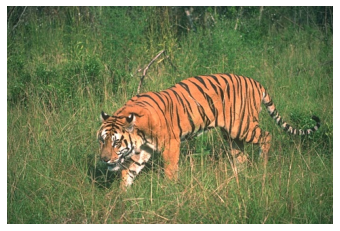

In [70]:
img_path = './test_imgs/108004.jpg'
save_path = './test_imgs/108004_result.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

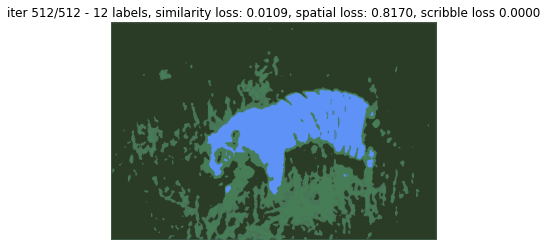

In [71]:
img_path = './test_imgs/108004.jpg'
save_path = './test_imgs/108004_result.jpg'
display.Image(cv2.imread(img_path))
unsupervised_segmentation(img_path=img_path, save_path=save_path)

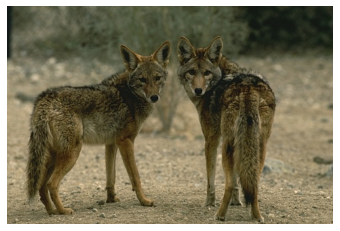

In [72]:
img_path = './test_imgs/196062.jpg'
save_path = './test_imgs/196062_result.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

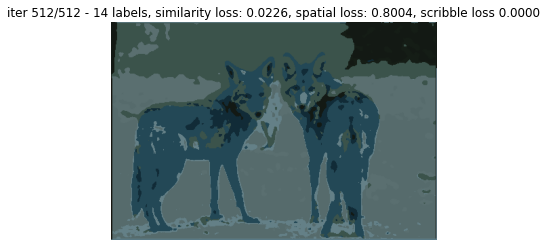

In [73]:
unsupervised_segmentation(img_path=img_path, save_path=save_path)

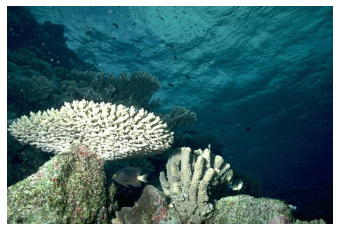

In [88]:
img_path = './test_imgs/101027.jpg'
save_path = './test_imgs/101027_result.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

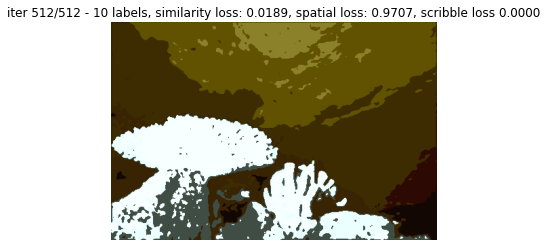

In [89]:
unsupervised_segmentation(img_path=img_path, save_path=save_path)

Then, we do comparison between w/o and w/ additional scribble from user:

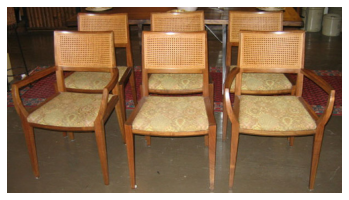

In [76]:
img_path = './test_imgs/2008_001439.jpg'
save_path = './test_imgs/2008_001439_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

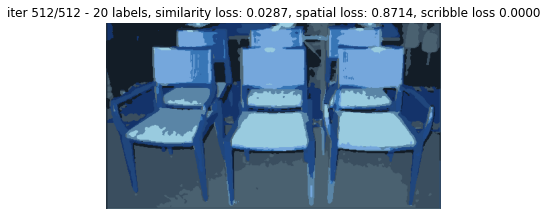

In [77]:
unsupervised_segmentation(img_path=img_path, save_path=save_path)

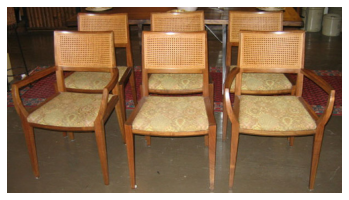

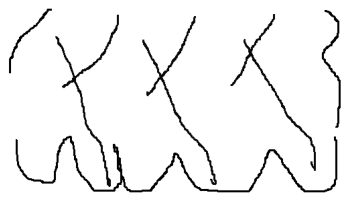

In [78]:
img_path = './test_imgs/2008_001439.jpg'
scribble_path = './test_imgs/2008_001439_scribble.png'
save_path = './test_imgs/2008_001439_scribble_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()
plt.axis('off')
plt.imshow(cv2.imread(scribble_path)[:, :, ::-1])
plt.show()

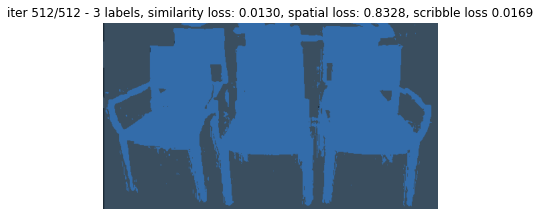

In [79]:
unsupervised_segmentation(img_path=img_path, save_path=save_path, scribble_path=scribble_path)

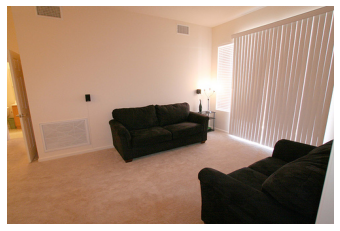

In [80]:
img_path = './test_imgs/2008_003709.jpg'
save_path = './test_imgs/2008_003709_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

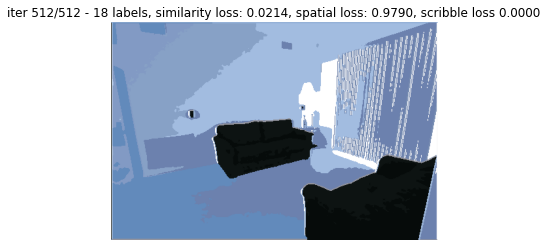

In [81]:
unsupervised_segmentation(img_path=img_path, save_path=save_path)

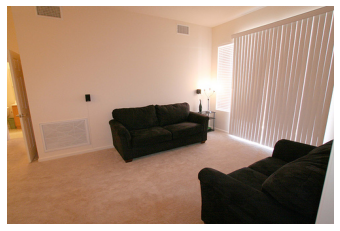

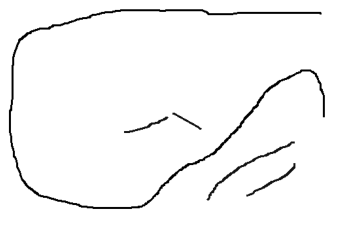

In [82]:
img_path = './test_imgs/2008_003709.jpg'
scribble_path = './test_imgs/2008_003709_scribble.png'
save_path = './test_imgs/2008_003709_scribble_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()
plt.axis('off')
plt.imshow(cv2.imread(scribble_path)[:, :, ::-1])
plt.show()

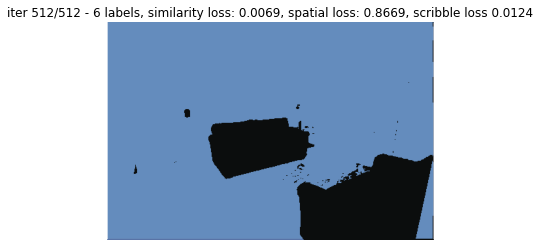

In [83]:
unsupervised_segmentation(img_path=img_path, save_path=save_path, scribble_path=scribble_path)

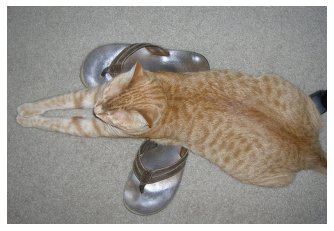

In [84]:
img_path = './test_imgs/2007_001774.jpg'
save_path = './test_imgs/2007_001774_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()

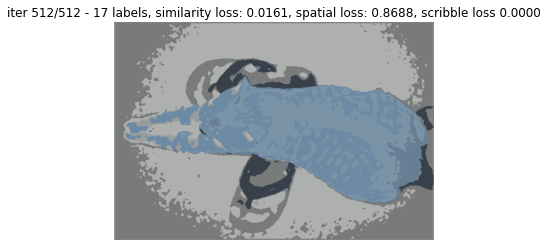

In [85]:
unsupervised_segmentation(img_path=img_path, save_path=save_path)

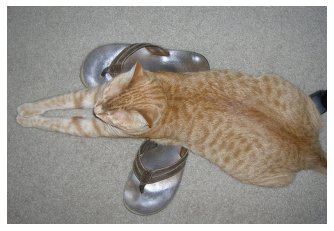

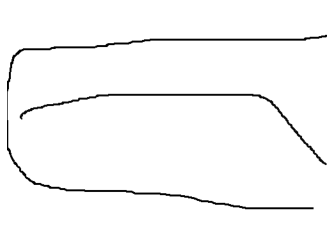

In [86]:
img_path = './test_imgs/2007_001774.jpg'
scribble_path = './test_imgs/2007_001774_scribble.png'
save_path = './test_imgs/2007_001774_scribble_results.jpg'
plt.axis('off')
plt.imshow(cv2.imread(img_path)[:, :, ::-1])
plt.show()
plt.axis('off')
plt.imshow(cv2.imread(scribble_path)[:, :, ::-1])
plt.show()

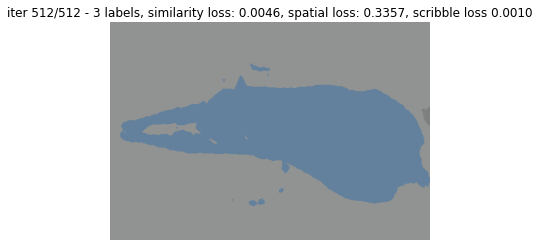

In [87]:
unsupervised_segmentation(img_path=img_path, save_path=save_path, scribble_path=scribble_path)

## Discussion and Conclusion
The results of the above experiments show that the idea of this paper is basically feasible. Although the segmentation results are rather coarse and have a tendency to over-segment, the performance is impressive enough for me as an unsupervised method. In particular, the results after providing the user scribbles are greatly enhanced compared to the results of entering only images.